# Quantum pipeline using the Quantum Trainer

In [3]:
from lambeq import BobcatParser, pregroups, AtomicType, SpacyTokeniser, Rewriter
import numpy as np

from lambeq import TketModel,remove_cups, QuantumTrainer, SPSAOptimizer
from pytket.extensions.qiskit import AerBackend

import matplotlib.pyplot as plt

from lambeq import AtomicType,BinaryCrossEntropyLoss, Dataset

from lambeq import NumpyModel

from lambeq import IQPAnsatz,Sim15Ansatz

from utils.FslAnsatz import FslBaseAnsatz, FslNN

import warnings
warnings.filterwarnings("ignore")

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

import torch
from torch import nn

OSError: [WinError 126] The specified module could not be found. Error loading "c:\Users\ucl_l\Documents\GitHub\FslQNLP\new\Lib\site-packages\torch\lib\fbgemm.dll" or one of its dependencies.

In [2]:

from lambeq import CircuitAnsatz

from discopy.quantum.circuit import Functor, Id
from discopy.quantum import Circuit, qubit
from discopy.quantum.gates import Ry, Rx, Rz, CRx

from discopy.grammar.pregroup import Box, Category, Diagram, Ty
from lambeq.ansatz import BaseAnsatz
from collections.abc import Callable, Mapping

import regex as re

from sklearn.manifold import TSNE

import torch

import numpy as np

from sympy import Symbol

from icecream import ic

class FslNN(CircuitAnsatz):
    def __init__(self,preq_embeddings, ob_map, n_layers, n_single_qubit_params = 2, discard = False):
        self.preq_embeddings=preq_embeddings
        super().__init__(ob_map,
                         n_layers,
                         n_single_qubit_params,
                         self.circuito,
                         discard,
                         [Rx,Ry])

    def circuito(self,n_qubits,params):
        pattern = '^\w+?(?=__)'
        word=params[0][0].name
        matches = re.search(pattern,word)
        word = matches.group(0)

        circuit=Id(n_qubits)

        if (n_qubits==1):
            circuit >>= Id().tensor(*[Rx(phase=Symbol(f'{word} 1'))])
            circuit >>= Id().tensor(*[Rz(phase=Symbol(f'{word} 2'))])

            return circuit

        #Pre Q embeddings
        circuit >>= Id().tensor(*[Rx(phase=phi) for phi in self.preq_embeddings[n_qubits][word][0:n_qubits]])
        circuit >>= Id().tensor(*[Ry(phase=phi) for phi in self.preq_embeddings[n_qubits][word][n_qubits:2*n_qubits]])
        for j in range(n_qubits - 1):
            circuit >>= Id(j) @ CRx(phase=self.preq_embeddings[n_qubits][word][2*n_qubits+j]) @ Id(n_qubits - j - 2)

        #W transform
        n_string=str(n_qubits)
        for m in range(n_layers):
            qubit_shift=m*(3*n_qubits-1)
            circuit >>= Id().tensor(*[Ry(Symbol(n_string+'_qubit_{}'.format(i+qubit_shift))) for i in range(n_qubits)])
            circuit >>= Id().tensor(*[Rz(Symbol(n_string+'_qubit_{}'.format(i+n_qubits+qubit_shift))) for i in range(n_qubits)])
            for j in range(n_qubits - 1):
                circuit >>= Id(j) @ CRx(Symbol(n_string+'_qubit_{}'.format(j+2*n_qubits+qubit_shift))) @ Id(n_qubits - j - 2)

        return circuit

    def params_shape(self, n_qubits):
        return (self.n_layers + 1, n_qubits)

KeyboardInterrupt: 

### NN preq

In [2]:
def get_NN(N_Qubits):
    N_PARAMS=3*N_Qubits-1
    class PreQ(nn.Module):
        def __init__(self):
            super(PreQ,self).__init__()
            self.flatten = nn.Flatten(start_dim=0)
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(300, 200),
                nn.ReLU(),
                nn.Linear(200, 100),
                nn.ReLU(),
                nn.Linear(100, 50),
                nn.ReLU(),
                nn.Linear(50,N_PARAMS)
            )
            self.double()

        def forward(self, x):
            #x = self.flatten(x)
            logits1=self.linear_relu_stack(x)


            return logits1

        def get_quantum_state(self,parameters):

            first_layer=torch.stack([self.recursiveRx(i,parameters,N_Qubits-1) for i in range(parameters.shape[0])])
            second_layer=torch.stack([self.recursiveRy(i,parameters,2*N_Qubits-1) for i in range(parameters.shape[0])])

            rotation_layers=[first_layer,second_layer]

            Cx_layers=[  kron(Id(i),kron(CRx(parameters[:,2*N_Qubits+i]),Id(N_Qubits-i-2))) for i in range(N_Qubits-1) ]

            all_layers=rotation_layers+Cx_layers
            
            output=self.compose(all_layers)        

            return output

        def recursiveRx(self, i, parameters,counter):        
            if counter==1:
                return kron(Rx(parameters[:,counter])[i],Rx(parameters[:,1])[i])
            else:
                return kron(self.recursiveRx(i,parameters,counter-1),Rx(parameters[:,counter])[i])

        def recursiveRy(self, i, parameters,counter):        
            if counter==N_Qubits+1:
                return kron(Ry(parameters[:,counter-1])[i],Ry(parameters[:,counter])[i])
            else:
                return kron(self.recursiveRy(i,parameters,counter-1),Ry(parameters[:,counter])[i])

        def compose(self,layers):

            if len(layers)==2:
                return bmm(layers[0],layers[1])
            
            else:
                last_element=layers.pop()
                return bmm(self.compose(layers),last_element)

    saved_model = PreQ()
    PATH=f'resources/embeddings/NN/AUW_{N_Qubits}_{N_PARAMS}/Models/best_model'
    saved_model.load_state_dict(torch.load(PATH))
    saved_model.eval()
    return saved_model
    

### Fsl ansatz

In [3]:
preq_embeddings={}
with open("resources\embeddings\common_crawl\glove.42B.300d.txt", 'r', encoding="utf-8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        preq_embeddings[word] = vector

### Read in the data and create diagrams

In [8]:
def get_unique_words(sentences):
    unique_words = set()
    
    for sentence in sentences:
        words = sentence.split()
        for word in words:
            # Remove punctuation and convert to lower case
            clean_word = ''.join(char for char in word if char.isalnum()).lower()
            if clean_word:
                unique_words.add(clean_word)
    
    return unique_words

In [9]:
def read_data(filename):
    labels, sentences = [], []
    with open(filename) as f:
        for line in f:
            t = int(line[0])
            labels.append([t, 1-t])
            sentences.append(line[1:].strip())
    return labels, sentences

In [10]:
train_labels, train_data = read_data('resources/dataset/new_mc_train_data.txt')
dev_labels, dev_data = read_data('resources/dataset/new_mc_dev_data.txt')
test_labels, test_data = read_data('resources/dataset/new_mc_test_data_seen.txt')
OOV_test_labels, OOV_test_data = read_data('resources/dataset/new_mc_test_data_OOV.txt')
redundant_test_labels, redundant_test_data = read_data('resources/dataset/new_mc_test_data_redundancy.txt')

In [11]:
all_sentences=train_data+dev_data+test_data+OOV_test_data+redundant_test_data
unique_words=get_unique_words(all_sentences)
unique_words.remove('1')
unique_words=list(unique_words)
values=[preq_embeddings.get(key) for key in unique_words]
unique_words_values=torch.tensor(values,dtype=torch.double)

In [14]:
NN_embeddings={}
for i in range(2,10):
    model=get_NN(i)
    outputs=model(unique_words_values).tolist()
    temp_dict={word:output for word,output in zip(unique_words,outputs)}
    NN_embeddings[i]=temp_dict

In [18]:
TESTING = int(os.environ.get('TEST_NOTEBOOKS', '0'))
TESTING=False
if TESTING:
    train_labels, train_data = train_labels[:2], train_data[:2]
    dev_labels, dev_data = dev_labels[:2], dev_data[:2]
    test_labels, test_data = test_labels[:2], test_data[:2]
    OOV_test_labels, OOV_test_data = OOV_test_labels[:2], OOV_test_data[:2]
    redundant_test_labels, redundant_test_data = redundant_test_labels[:2], redundant_test_data[:2]
    EPOCHS = 1

### Create diagrams

In [12]:
parser = BobcatParser(verbose='text')
tokeniser = SpacyTokeniser()


In [ ]:

raw_train_tokens = tokeniser.tokenise_sentences(train_data)
raw_train_tokens = [tokens[:-1] for tokens in raw_train_tokens]

raw_dev_tokens = tokeniser.tokenise_sentences(dev_data)
raw_dev_tokens = [tokens[:-1] for tokens in raw_dev_tokens]


raw_test_tokens = tokeniser.tokenise_sentences(test_data)
raw_test_tokens =  [tokens[:-1] for tokens in raw_test_tokens]

raw_OOV_test_tokens = tokeniser.tokenise_sentences(OOV_test_data)
raw_OOV_test_tokens = [tokens[:-1] for tokens in raw_OOV_test_tokens]

raw_redundancy_test_tokens = tokeniser.tokenise_sentences(redundant_test_data)
raw_redundancy_test_tokens = [tokens[:-1] for tokens in raw_redundancy_test_tokens]

raw_train_diagrams = parser.sentences2diagrams(raw_train_tokens,tokenised=True)
raw_dev_diagrams = parser.sentences2diagrams(raw_dev_tokens,tokenised=True)
raw_test_diagrams = parser.sentences2diagrams(raw_test_tokens,tokenised=True)
raw_OOV_test_diagrams = parser.sentences2diagrams(raw_OOV_test_tokens,tokenised=True)
raw_redundancy_test_diagrams = parser.sentences2diagrams(raw_redundancy_test_tokens,tokenised=True)

### Remove the cups

In [22]:
train_diagrams = [remove_cups(diagram) for diagram in raw_train_diagrams]
dev_diagrams = [remove_cups(diagram) for diagram in raw_dev_diagrams]
test_diagrams = [remove_cups(diagram) for diagram in raw_test_diagrams]
OOV_test_diagrams = [remove_cups(diagram) for diagram in raw_OOV_test_diagrams]
redundancy_test_diagrams = [remove_cups(diagram) for diagram in raw_redundancy_test_diagrams]

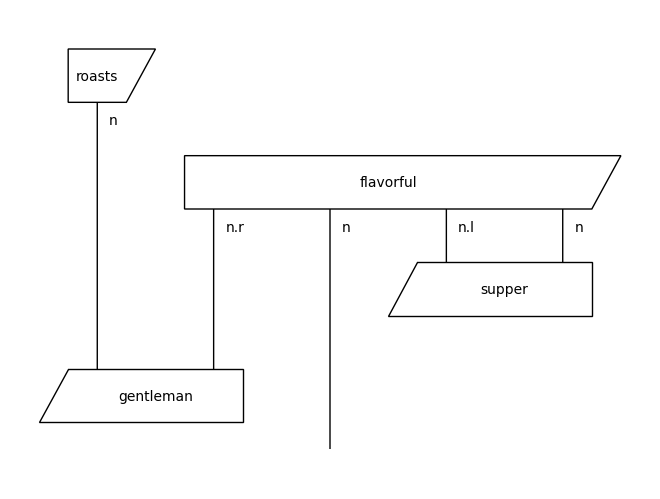

In [23]:
train_diagrams[1].draw()

### Create circuits

#### Variables

In [15]:
# Define atomic types
N = AtomicType.NOUN
S = AtomicType.SENTENCE
map={N:2,S:1}
n_layers=1
alpha="Sim15Ansatz"
beta="FslBase"
gamma="FslNN"
ansatz_string=gamma
print(ansatz_string)
match ansatz_string:
    case "FslBase":
        ansatz = FslBaseAnsatz(preq_embeddings,map, n_layers=n_layers)
    case "FslSim15":
        ansatz = FslSim15Ansatz(preq_embeddings,map, n_layers=n_layers)  
    case "FslNN":
        ansatz = FslNN(preq_embeddings=NN_embeddings,ob_map=map,n_layers=n_layers)

FslNN


In [131]:
NN_embeddings[2]

{'code': tensor([-0.0391,  0.1653, -0.0110, -0.0022, -0.1010], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'grills': tensor([-0.0183,  0.1992, -0.0093, -0.0025, -0.0984], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'flavorful': tensor([-0.0175,  0.1895, -0.0105, -0.0030, -0.0996], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'interesting': tensor([-0.0406,  0.1693, -0.0089, -0.0023, -0.1035], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'adept': tensor([-0.0452,  0.1561, -0.0097, -0.0017, -0.0865], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'practical': tensor([-0.0371,  0.1649, -0.0109, -0.0021, -0.1050], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'skillful': tensor([-0.0518,  0.1532, -0.0102, -0.0021, -0.0817], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'chicken': tensor([-0.0278,  0.1823, -0.0091, -0.0023, -0.0996], dtype=torch.float64,
        grad_fn=<UnbindBackward0>),
 'helpful': t

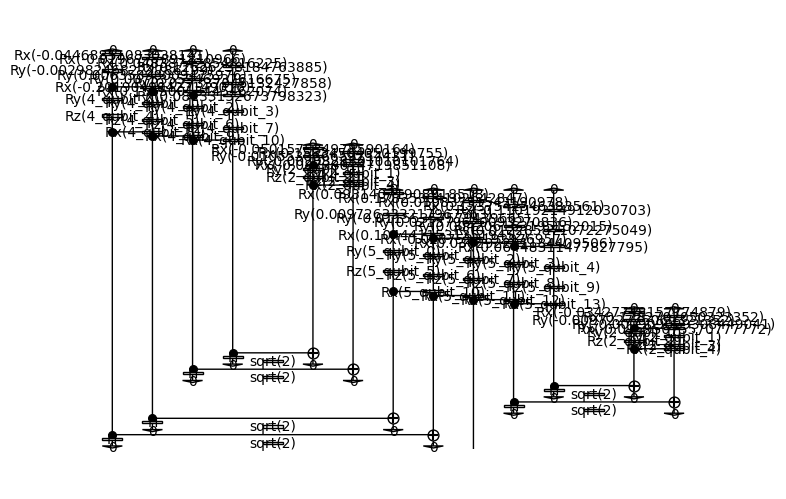

In [16]:
diagram=parser.sentence2diagram('masterful guy bakes soup')
ansatz(diagram).draw()

#### Create circits

In [44]:
train_circuits = [ansatz(diagram) for diagram in train_diagrams]
dev_circuits =  [ansatz(diagram) for diagram in dev_diagrams]
test_circuits = [ansatz(diagram) for diagram in test_diagrams]
OOV_test_circuits = [ansatz(diagram) for diagram in OOV_test_diagrams]
redundancy_test_circuits = [ansatz(diagram) for diagram in redundancy_test_diagrams]

In [45]:
len(train_circuits)

1400

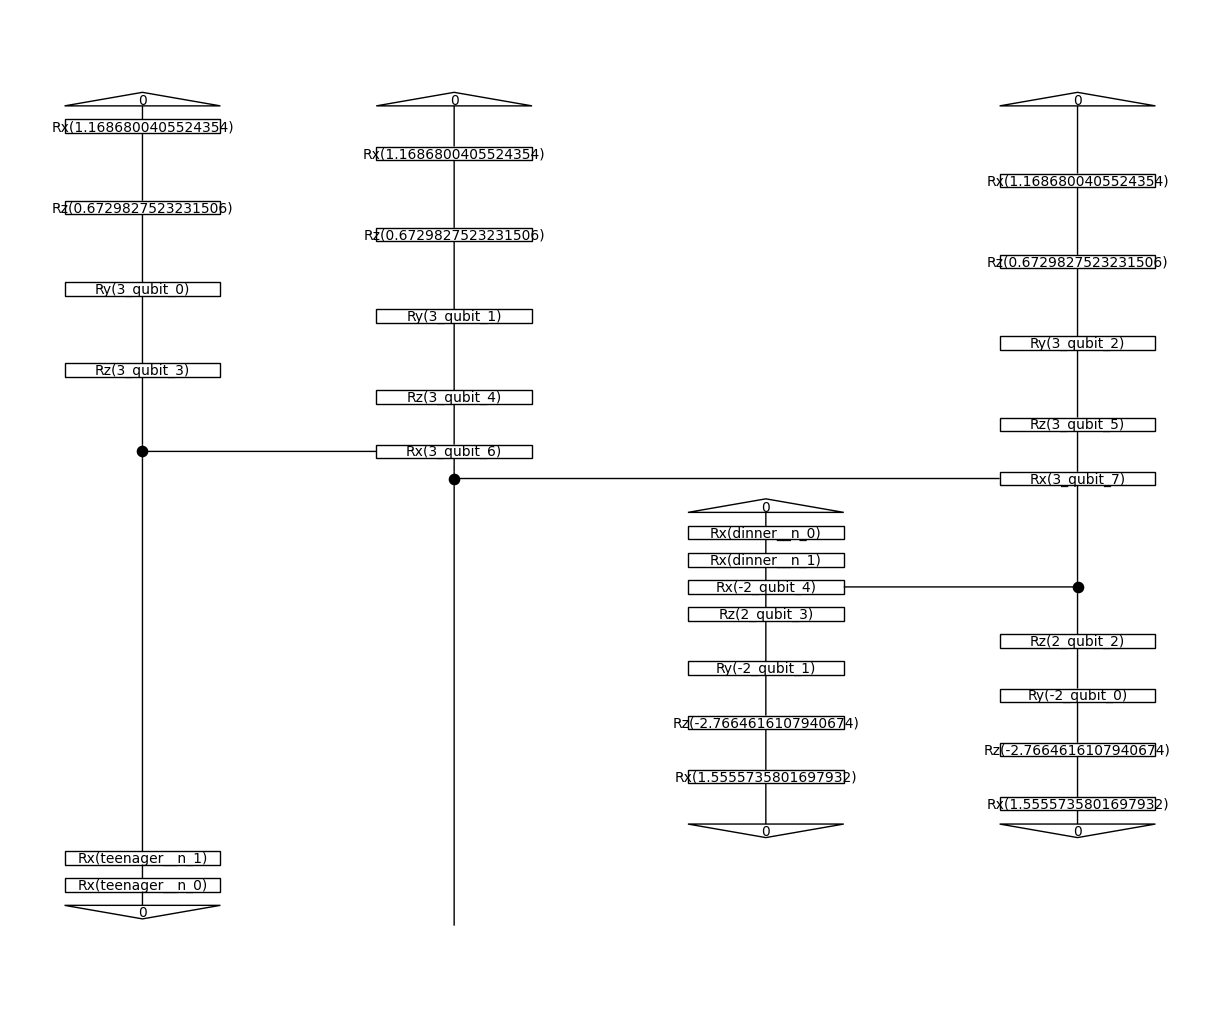

In [42]:
train_circuits[1].draw(figsize=(12, 10))

### Parameterise

In [46]:
all_circuits = train_circuits+dev_circuits+test_circuits

#### TketModel

In [18]:
backend = AerBackend()
backend_config = {
    'backend': backend,
    'compilation': backend.default_compilation_pass(2),
    'shots': 8192
}
model = TketModel.from_diagrams(all_circuits, backend_config=backend_config)

#### NumpyModel

In [47]:
model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

In [ ]:
for i in range(0,len(all_circuits)):
    try:
        acc(model([all_circuits[i]]), test_labels)
    except:
        print(i)

In [36]:
a=all_circuits[1]
a.eval()

AttributeError: 'ImmutableDenseNDimArray' object has no attribute 'as_coefficient'

### Define evaluation metric

In [49]:
# Using the builtin binary cross-entropy error from lambeq
bce = BinaryCrossEntropyLoss()
loss_function="BindaryCrosEntropyLoss"
acc_function="lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2"
acc = lambda y_hat, y: np.sum(np.round(y_hat) == y) / len(y) / 2  # half due to double-counting

### Initialize trainer

In [51]:
checkpoint=False
EPOCHS=2000
BATCH_SIZE = 1500
SEED = 2
a=0.05
c=0.06
A="0.1*Epochs"
logdir='runs\Baseline\Epochs_{}--A_{}--N_{}--S_{}--L_{}--Ansatz_{}'.format(EPOCHS,a,map[N],map[S],n_layers,ansatz_string)


In [42]:
if checkpoint:
    model=NumpyModel.from_checkpoint(logdir+'\model.lt')
    print('Checkpoint')

In [52]:
trainer = QuantumTrainer(
    model,
    loss_function=bce,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': a, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': acc},
    evaluate_on_train=True,
    verbose = 'text',
    seed=0,
    from_checkpoint=checkpoint,
    log_dir=logdir
)

In [53]:
train_dataset = Dataset(
            train_circuits,
            train_labels,
            batch_size=BATCH_SIZE)

val_dataset = Dataset(dev_circuits, dev_labels, shuffle=False)

### Train

In [54]:
trainer.fit(train_dataset, val_dataset, log_interval=10, eval_interval=1)

ValueError: All input arrays must have the same shape.

### Show results

Test accuracy: 0.5


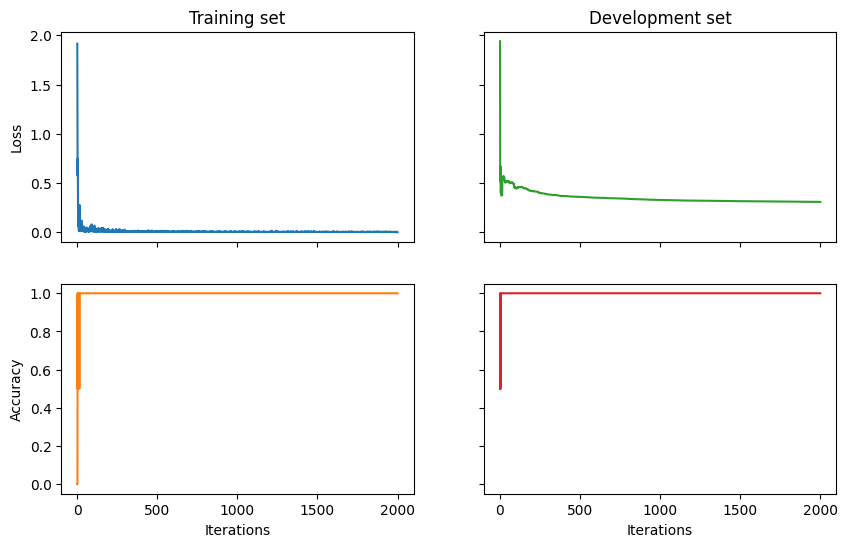

In [21]:
fig, ((ax_tl, ax_tr), (ax_bl, ax_br)) = plt.subplots(2, 2, sharex=True, sharey='row', figsize=(10, 6))
ax_tl.set_title('Training set')
ax_tr.set_title('Development set')
ax_bl.set_xlabel('Iterations')
ax_br.set_xlabel('Iterations')
ax_bl.set_ylabel('Accuracy')
ax_tl.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
range_ = np.arange(1, trainer.epochs + 1)
ax_tl.plot(range_, trainer.train_epoch_costs, color=next(colours))
ax_bl.plot(range_, trainer.train_eval_results['acc'], color=next(colours))
ax_tr.plot(range_, trainer.val_costs, color=next(colours))
ax_br.plot(range_, trainer.val_eval_results['acc'], color=next(colours))
plt.savefig(logdir+'\plot.png')

In [ ]:

model=NumpyModel.from_checkpoint(logdir+'\\model.lt')
test_acc = acc(model(test_circuits), test_labels)

best_model=NumpyModel.from_checkpoint(logdir+'\\best_model.lt')
best_model_test_acc = acc(best_model(test_circuits), test_labels)
#test_acc = acc(model(test_circuits), test_labels)
print('Test accuracy:', test_acc)


### saving everything

In [22]:
file_path = f"{logdir}/info_file.txt"
with open(file_path, 'w') as file:
    # Write the input string to the file
    input_string=f"""Task: Meaning classification
Classical Embeddings: GloVe 50-d
Parsing: True
Rewritign: Remove Cups
Ansatz: {ansatz_string}
Layers: {n_layers}
Map: [N:{map[N]}, S:{map[S]}]
Model: Numpy
Backend: None
Trainer: Quantum Trainer
Loss function: {loss_function}
Accuracy function: {acc_function}
Optimizer: SPSA optimizer
Epochs: {EPOCHS}
Batch size: {BATCH_SIZE}
Seed: {SEED}
Hyperparams: [a:{a},c:{c},A:{A}]
Test accuracy: {test_acc}
Test accuracy best model: {best_model_test_acc}"""
    file.write(input_string)